# Fama-French 三因子在A股市场的实证研究

Fama-French三因子模型无疑是量化领域最经典的模型之一，该模型的提出是在论文《commom risk factors in returns on bonds and stocks>里，本帖本着学习的精神对其进行了学习，并使用论文中的方法在中国A股市场上进行了实证。
\begin{align*}
E(R(t))=R_f(t)+bE(R_M(t)-R_f(t))+sE(SMB(t))+hE(HML(t))
\end{align*}

$R_M-R_f$表示的是市场因子，$SMB$表示的是规模(市值)因子，$HML$表示账面市值比因子

# 一.背景
资本资产定价模型（CAPM）问世以后，许多学者对其进行了实证研究，如Black和Scholes（1972）及Fama(1973)的检验证明，对1969年以前的数据而言，资本资产定价模型是有效的，而对之后的数据，却缺乏说服力。在横截面数据里，股票的平均收益和市场$\beta$相关性很低，因而更多影响股票收益的因素亟待发掘。

Fama和French(1992)研究了市场$\beta$, 市值(size), 账面市值比(book-to-market equity),财务杠杆(leverage) 和市盈率(E/P)对平均收益的影响。横截面回归后发现，在独立检验四者对平均收益的影响时，四者都表现出了很强的解释能力，而$\beta$很弱；在进行多变量回归时，市值和账面市值比这两个因子吸收了另两个因子的解释能力，成为了解释平均收益的决定性变量

1993年，Fama和French的论文《commom risk factors in returns on bonds and stocks〉正式标志着三因子模型的建立。在该论文里，他们不仅研究了影响股票收益的因子模型，还研究了对债券收益的因子模型；更重要的是，不同于以往的横截面回归，该论文使用了Black,Jensen和Scholes的时间序列回归方法，对影响股票收益的市场超额收益，规模和账面市值比三个因子进行了实证研究。

下面，本帖就论文里对股票三因子模型的研究思路，在优矿平台上对中证800成分股从2007.6到2016.5的数据进行了实证研究，以验证三因子模型的有效性。

# 二.研究思路
## 1.Black-Jensen-Scholes时间序列回归
横截面回归大家都非常熟悉，无论是单变量还是多变量回归，都是在研究解释变量对响应变量的解释能力。Black-Jensen-Scholes时间序列回归的方法是Black,Jensen和Scholes所提出来验证CAPM的。早期的验证方法是先使用一个单只股票的时间序列回归估计贝塔，再用横截面回归验证CAPM推出的假设。但是这样回归会有误差项存在相关性，贝塔非平稳等问题，时间序列回归则避免了这些问题。即根据前一期估计的贝塔值对股票排序再进行分组，分别估计各投资组合的阿尔法和贝塔，每五年重新估计贝塔，然后检验各个投资组合的阿尔法是否显著为0,从而验证CAPM
\begin{align*}
E(R(t))=R_f(t) +\beta(E(R_M(t))-R_f(t))
\end{align*}

## 2.解释变量
解释变量就是我们需要验证的三个因子，市场超额收益，规模和账面市值比。我们要按照论文里的思路对其进行处理。

## 1）分组
把股票按每年6月末时的市值（size）大小进行排序，按照50%分位值把股票分为S(small)和B(big)两组；

再依据5月末时的账面市值比（我们取1/PB）大小对800只股票进行排序，分为L（low，30%）,M(medium,40%),H(high,30%)三组;

再分别对S,B和L,M,H取交集，股票即被分为了SL,SM,SH,BL,BM,BH六组。

也就是说，分组每年6月末进行一次，800只股票每次被重新分为了SL,SM,SH,BL,BM,BH六组，前一年6月到第二年5月重新分组时的投资组合都是一样的

这里为什么要按市值分为两组，按账面市值比分为三组呢？
是因为账面市值比有更强的作用，我们要把它分得更细。

In [385]:
import numpy as np
import pandas as pd
import scipy
import math
import statsmodels
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from WindPy import w
import calendar
import numpy as np
import scipy.stats as stats
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

In [386]:
sns.set(style="darkgrid")

In [387]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [388]:
breakpoint = "20160630"

### 提取所有沪深300/万得全A指数成分股

In [389]:
codes = w.wset("IndexConstituent","date=%s;windcode=881001.WI;field=wind_code"%(breakpoint))

In [390]:
codes = codes.Data[0]

In [391]:
codes[:10]

[u'000001.SZ',
 u'000002.SZ',
 u'000004.SZ',
 u'000005.SZ',
 u'000006.SZ',
 u'000007.SZ',
 u'000008.SZ',
 u'000009.SZ',
 u'000010.SZ',
 u'000011.SZ']

In [392]:
def get_account_data(symbols, factors, date):
    raw_data = w.wss(symbols, ",".join(factors), "tradeDate=%s;ruleType=3"%(date))
    dic = {"ticker": symbols}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str.lower(str(field))] = data
    return pd.DataFrame(dic)

In [393]:
ME = get_account_data(codes, ["mkt_cap"], breakpoint) #取当时的市值

In [394]:
ME.head()

,mkt_cap,ticker
0,1.493826e+11,000001.SZ
1,2.696865e+11,000002.SZ
2,3.092861e+09,000004.SZ
3,7.981368e+09,000005.SZ
4,9.949463e+09,000006.SZ


In [395]:
def get_6groups(breakpoint):
    codes = w.wset("IndexConstituent","date=%s;windcode=000300.SH;field=wind_code"%(breakpoint))
    codes = codes.Data[0]
    
    ME = get_account_data(codes, ["mkt_cap"], breakpoint) #取当时的市值
    ME50 = np.percentile(ME['mkt_cap'], 50) #算出市值大小的50%分位值
    S = ME[ME['mkt_cap'] <= ME50]['ticker'].tolist() #按市值大小分为两组，存为列表
    B = ME[ME['mkt_cap'] > ME50]['ticker'].tolist()
    
    BP = get_account_data(codes, ["pb"], breakpoint)
    BP = BP[BP > 0].dropna() #去掉PB值为负的股票
    BP[['pb']]=1 / BP[['pb']] #取1/PB，为账面市值比
    BP30 = np.percentile(BP['pb'],30)
    BP70 = np.percentile(BP['pb'],70)
    L = BP[BP['pb'] <= BP30]['ticker'].tolist() #按1/PB大小分为三组
    H = BP[BP['pb'] > BP70]['ticker'].tolist()
    M = list(set(BP['ticker'].tolist()).difference(set(L+H)))
    
    SL=list(set(S).intersection(set(L))) #对S组和L组的股票取交集，作为SL组的股票组合
    SM=list(set(S).intersection(set(M)))
    SH=list(set(S).intersection(set(H)))
    BL=list(set(B).intersection(set(L)))
    BM=list(set(B).intersection(set(M)))
    BH=list(set(B).intersection(set(H)))
    return SL, SM, SH, BL, BM, BH

In [95]:
[SL, SM, SH, BL, BM, BH] = get_6groups(breakpoint)

下面我们要计算每个投资组合的月收益率，计算投资组合的月收益率时，要算市值加权的收益率，这是为了最小化方差（风险）

In [176]:
def get_returnMonthly(codes, Year):
    raw_data = w.wsd(codes, "close", beginTime=Year+"0630", endTime=str(int(Year)+1)+"0630")
    dic = {}
    for data, code in zip(raw_data.Data, raw_data.Codes):
        dic[str.lower(str(code))] = data
    df = pd.DataFrame(dic)
    df.index = [x for x in raw_data.Times]
    df = df.resample('BM').last()
    
    returnMonthly=np.zeros(12)
    for i in range(df.index.shape[0] - 1):
        inf1 = pd.DataFrame(df.iloc[i, :]) #前一个月的收盘价
        inf2 = pd.DataFrame(df.iloc[i + 1, :]) ##当月的收盘价
        inf3 = w.wss(codes, "mkt_cap", "tradeDate=%s;ruleType=3"%(df.index[i + 1].strftime("%Y%m%d")))
        dic = {}
        for data, code in zip(inf3.Data[0], inf3.Codes):
            dic[str.lower(str(code))] = [data]
        inf3 = pd.DataFrame(dic).T #当月的市值

        Return = pd.concat([inf3, inf2, inf1], axis=1)
        Return.columns=['Weight','Return','WReturn']
        Return['Weight'] = Return['Weight'] / Return['Weight'].sum()
        Return['Return'] = Return['Return'] / Return['WReturn'] - 1
        Return['WReturn'] = Return['Weight'] * Return['Return']
        returnMonthly[i] = Return['WReturn'].sum()
    return returnMonthly

In [177]:
r_SL = get_returnMonthly(SL, "2015")

In [178]:
r_SL

array([-0.08889369, -0.13175659, -0.0422381 ,  0.15993147,  0.04089647,
        0.07074033, -0.2529885 , -0.04183556,  0.17086679, -0.06070154,
       -0.04352905, -0.03159452])

## 2）因子
市值因子：
\begin{align*}
SMB = 1/3*(SL+SM+SH)-1/3*(BL+BM+BH)
\end{align*}
表示的是由于公司规模不同造成的风险溢价

账面市值比因子:
\begin{align*}
HML = (SH+BH)/2-(SL+BL)/2
\end{align*}
表示由于账面市值比不同造成的风险溢价

可以看出因子的值是一个市值加权月收益率序列,我们研究了九年的数据，所以因子的长度是9*12=108

In [396]:
#计算每年的SMB和HML因子，合在一起
SMB=[]
HML=[]
r_groups = pd.DataFrame()  #用于存储每个组合的月收益率序列，方便我们之后查看
r_groups['SL'] = np.zeros(108)
r_groups['SM'] = np.zeros(108)
r_groups['SH'] = np.zeros(108)
r_groups['BL'] = np.zeros(108)
r_groups['BM'] = np.zeros(108)
r_groups['BH'] = np.zeros(108)
for year in ["2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015"]:
    print year
    
    SL,SM,SH,BL,BM,BH = get_6groups(year + "0630")  #依据当年6月末的市值和账面市值比分组
    r_SL = get_returnMonthly(SL, year)       #得到当年6月末到次年的市值加权月收益率序列
    r_SM = get_returnMonthly(SM, year)
    r_SH = get_returnMonthly(SH, year)
    r_BL = get_returnMonthly(BL, year)
    r_BM = get_returnMonthly(BM, year)
    r_BH = get_returnMonthly(BH, year)
    
    r_groups.iloc[(int(year)-2007)*12:(int(year)-2006)*12,[0]] = r_SL.reshape(12, 1)   #把组合SL当年6月末到次年的市值加权月收益率序列
    r_groups.iloc[(int(year)-2007)*12:(int(year)-2006)*12,[1]] = r_SM.reshape(12, 1)
    r_groups.iloc[(int(year)-2007)*12:(int(year)-2006)*12,[2]] = r_SH.reshape(12, 1)
    r_groups.iloc[(int(year)-2007)*12:(int(year)-2006)*12,[3]] = r_BL.reshape(12, 1)
    r_groups.iloc[(int(year)-2007)*12:(int(year)-2006)*12,[4]] = r_BM.reshape(12, 1)
    r_groups.iloc[(int(year)-2007)*12:(int(year)-2006)*12,[5]] = r_BH.reshape(12, 1)
    
    SMBr = (r_SL+r_SM+r_SH) / 3 - (r_BL+r_BM+r_BH) / 3                         #当年的SMB和HML因子，存为list
    HMLr = (r_SH+r_BH) / 2 - (r_SL+r_BL) / 2   
    SMB += SMBr.tolist()
    HML += HMLr.tolist()
    
SMB=np.array(SMB)
HML=np.array(HML)

2007
2008
2009
2010
2011
2012
2013
2014
2015


In [397]:
raw_data = w.wsd("881001.WI", "close", beginTime="20070601", endTime="20160630")
dic = {}
for data, code in zip(raw_data.Data, raw_data.Codes):
    dic[str.lower(str(code))] = data
rm_df = pd.DataFrame(dic, index=raw_data.Times)

In [398]:
rm_df = rm_df.resample('BM').last()

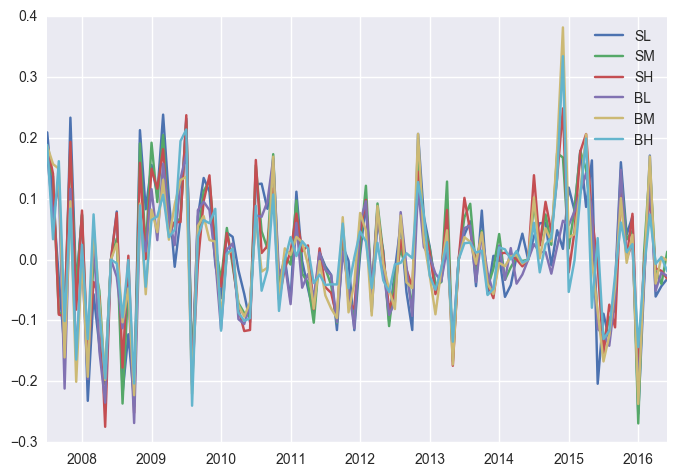

In [399]:
r_groups.index = rm_df.index[1:]
r_groups.plot()

市场因子：
\begin{align*}
R_M-R_f
\end{align*}
RM取的就是中证800指数的收益，Rf取的是银行间质押式回购利率_同业拆借中心R007

In [400]:
raw_data = w.wsd('DR007.IB', "close", beginTime="20070601", endTime="20160630")

In [401]:
dic = {}
for data, code in zip(raw_data.Data, raw_data.Codes):
    dic[str.lower(str(code))] = data
rf_df = pd.DataFrame(dic, index=raw_data.Times)

In [402]:
rf_df = rf_df.resample('BM').last()
rf_df = rf_df / 100 / 12 #给出的是年化无风险收益，这里需要转化成月的

In [406]:
MF = rm_df.pct_change()["881001.wi"][1:] - rf_df["dr007.ib"][1:]

In [407]:
MF = MF.values

三个因子我们都得到了，再来看看三个因子的状况：

,MF,SMB,HML
count,108.000000,108.000000,108.000000
mean,0.005931,0.009294,0.005055
std,0.097635,0.046638,0.053438
min,-0.277488,-0.214713,-0.124457
25%,-0.053915,-0.014806,-0.026530
50%,0.017559,0.011473,0.000304
75%,0.056967,0.032469,0.028142
max,0.192625,0.116626,0.250414


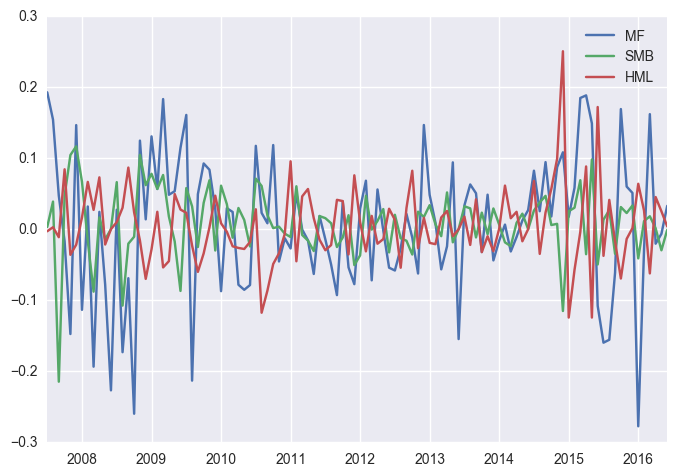

In [408]:
factor=pd.DataFrame()
factor['MF'] = MF
factor['SMB'] = SMB
factor['HML'] = HML
factor.index = r_groups.index
factor.plot()
factor.describe()

到这里，我们的三个因子就处理完了，三个解释变量都做成了数组，下面可以分析一下各个因子之间的相关系数

In [409]:
x = np.zeros((3,108))
x[0] = MF
x[1] = SMB
x[2] = HML
Correlations = pd.DataFrame(np.corrcoef(x))
Correlations.columns = ['MF','SMB','HML']
Correlations.index = ['MF','SMB','HML']
Correlations

,MF,SMB,HML
MF,1.000000,0.262965,-0.121270
SMB,0.262965,1.000000,-0.433091
HML,-0.121270,-0.433091,1.000000


### 市场收益率与SMB和HML的关系

In [444]:
df = pd.DataFrame({"market return": rm_df.pct_change()["881001.wi"][1:], "SMB": SMB, "HML": HML, "MF": MF})

In [445]:
df.head()

,HML,MF,SMB,market return
2007-07-31,-0.002965,0.192625,0.003053,0.194875
2007-08-31,0.002690,0.154085,0.038797,0.156118
2007-09-28,-0.011347,0.047017,-0.214713,0.048267
2007-10-31,0.084239,-0.017201,0.047252,-0.014492
2007-11-30,-0.036121,-0.147596,0.104313,-0.145313


In [446]:
X = sm.add_constant(df["SMB"])

In [447]:
y = df["market return"]

In [448]:
model = sm.OLS(y, X)

In [449]:
result = model.fit()

In [450]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.060    
Dependent Variable: market return    AIC:                -201.0781
Date:               2017-02-15 10:28 BIC:                -195.7139
No. Observations:   108              Log-Likelihood:     102.54   
Df Model:           1                F-statistic:        7.801    
Df Residuals:       106              Prob (F-statistic): 0.00620  
R-squared:          0.069            Scale:              0.0089325
---------------------------------------------------------------------
          Coef.     Std.Err.      t       P>|t|      [0.025    0.975]
---------------------------------------------------------------------
const     0.0035      0.0093    0.3768    0.7071    -0.0149    0.0219
SMB       0.5472      0.1959    2.7931    0.0062     0.1588    0.9356
------------------------------------------------------------------
Omnibus:              5.187         Durbin-Watson:           1.739
Prob(Omnibus):        0.075         Jarque-Bera (JB):        4.561
Skew:                 -0.442        Prob(JB):                0.102
Kurtosis:             3.482         Condition No.:           22   
==================================================================

"""

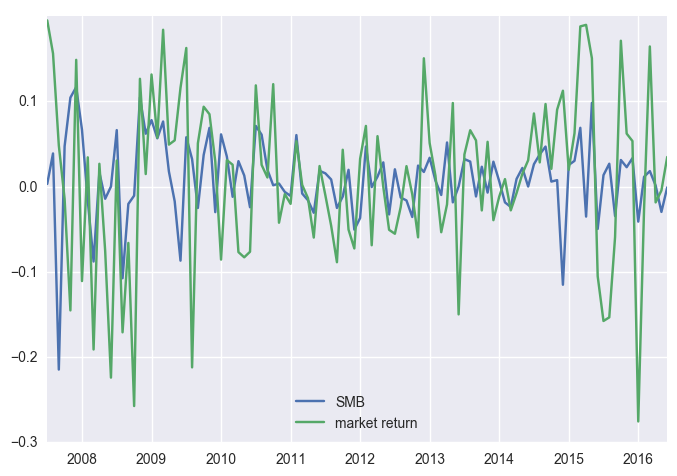

In [452]:
df[["SMB", "market return"]].plot()

# 3. 响应变量
首先我们将股票按之前的方法分为25个组合，即：

在每年6月末，按照市值大小将股票排序并分为5组，然后按照账面市值比大小把股票分为5组，交叉取交集，得到5*5=25个股票组合

也就是说，我们将作25个回归，每次回归时的解释变量都一样，响应变量不同

In [237]:
def get_25groups(breakpoint):
    codes = w.wset("IndexConstituent","date=%s;windcode=000300.SH;field=wind_code"%(breakpoint))
    codes = codes.Data[0]
    
    ME = get_account_data(codes, ["mkt_cap"], breakpoint) #取当时的市值
    MEq = np.zeros(6) #用于存储ME的分位值
    ME_5 = pd.Series([]) #用于存储依据市值分好的5个组
    
    BP = get_account_data(codes, ["pb"], breakpoint)
    BP = BP[BP>0].dropna() #去掉PB值为负的股票
    BP[['pb']] = 1 / BP[['pb']] #取1/PB，为账面市值比
    BPq = np.zeros(6)  #用于存储1/PB的分位值
    BP_5 = pd.Series([]) #用于存储依据账面市值比分好的5个组
    
    for i in range(5):
        MEq[i+1] = np.percentile(ME['mkt_cap'], (i+1)*20) #算出市值大小的20%,40%,60%,80%分位值
        BPq[i+1] = np.percentile(BP['pb'], (i+1)*20)
        
        D = ME[(ME['mkt_cap'] > MEq[i]) & (ME['mkt_cap'] <= MEq[i+1])]['ticker'].tolist() #取市值处于相应分位值区间的股票
        if i == 0:
            ME_5 = pd.Series(D)
        else:
            ME_5 = pd.concat([ME_5, pd.Series(D)], axis=1)
        
        E = BP[(BP['pb'] > BPq[i]) & (BP['pb'] <= BPq[i+1])]['ticker'].tolist()
        if i == 0:
            BP_5 = pd.Series(D)
        else:
            BP_5 = pd.concat([BP_5, pd.Series(E)], axis=1)
    ME_5.columns = range(5) #重命名列名
    BP_5.columns = range(5)
    Group25 = pd.Series([]) #用于存著交叉取交集后的25个股票组合
    for i in range(5):
        for j in range(5):
            s1 = ME_5[i].dropna().tolist()
            s2 = BP_5[j].dropna().tolist() 
            stocks = pd.Series(list(set(s1).intersection(set(s2)))) #取交集
            if i == 0 and j == 0:
                Group25 = stocks
            else:
                Group25 = pd.concat([Group25,stocks], axis=1)
    Group25.columns = range(25)
    return Group25

计算25个股票组合，每个组合的市值加权月收益率序列

In [267]:
a = {}
for i in range(25):
    a[i] = []
for year in ["2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015"]:
    print year
    Group25 = get_25groups(year+"0630")   #每年进行分组
    for i in range(25):
        temp = get_returnMonthly(Group25[i].dropna().tolist(), year).tolist()
        a[i] = a[i] + temp   #收益率转化为list，方便每年相加
        print i, len(a[i]), len(temp)

2007
0 12 12
1 12 12
2 12 12
3 12 12
4 12 12
5 12 12
6 12 12
7 12 12
8 12 12
9 12 12
10 12 12
11 12 12
12 12 12
13 12 12
14 12 12
15 12 12
16 12 12
17 12 12
18 12 12
19 12 12
20 12 12
21 12 12
22 12 12
23 12 12
24 12 12
2008
0 24 12
1 24 12
2 24 12
3 24 12
4 24 12
5 24 12
6 24 12
7 24 12
8 24 12
9 24 12
10 24 12
11 24 12
12 24 12
13 24 12
14 24 12
15 24 12
16 24 12
17 24 12
18 24 12
19 24 12
20 24 12
21 24 12
22 24 12
23 24 12
24 24 12
2009
0 36 12
1 36 12
2 36 12
3 36 12
4 36 12
5 36 12
6 36 12
7 36 12
8 36 12
9 36 12
10 36 12
11 36 12
12 36 12
13 36 12
14 36 12
15 36 12
16 36 12
17 36 12
18 36 12
19 36 12
20 36 12
21 36 12
22 36 12
23 36 12
24 36 12
2010
0 48 12
1 48 12
2 48 12
3 48 12
4 48 12
5 48 12
6 48 12
7 48 12
8 48 12
9 48 12
10 48 12
11 48 12
12 48 12
13 48 12
14 48 12
15 48 12
16 48 12
17 48 12
18 48 12
19 48 12
20 48 12
21 48 12
22 48 12
23 48 12
24 48 12
2011
0 60 12
1 60 12
2 60 12
3 60 12
4 60 12
5 60 12
6 60 12
7 60 12
8 60 12
9 60 12
10 60 12
11 60 12
12 60 12
13 60 12

In [282]:
EReturn = np.zeros((25, 12*9)) #用于存储25个组合的超额收益序列
for i in range(25):
    EReturn[i, :] = np.array(a[i]) - rf_df["dr007.ib"].values[1:]

看一下25个组合超额收益的均值和方差：

In [284]:
EReturn_mean = np.zeros(25)
for i in range(25):
    EReturn_mean[i] = EReturn[i].mean()
mean = pd.DataFrame(EReturn_mean.reshape(5, 5))
mean.columns = ['small_BE/ME','1','2','3','big_BE/ME']
mean.index = ['small_size','1','2','3','big_size']

In [285]:
mean

,small_BE/ME,1,2,3,big_BE/ME
small_size,0.013450,0.015131,0.016159,0.008277,0.010358
1,-0.002649,0.005285,0.000534,0.006488,0.006772
2,-0.002649,0.001281,0.007701,0.011316,0.010581
3,-0.002649,-0.003894,0.003454,0.006577,0.004386
big_size,-0.002649,-0.008120,0.001350,-0.001827,0.001151


In [286]:
EReturn_std = np.zeros(25)
for i in range(25):
    EReturn_std[i] = EReturn[i].std()
std = pd.DataFrame(EReturn_std.reshape(5, 5))
std.columns = ['small_BE/ME','1','2','3','big_BE/ME']
std.index = ['small_size','1','2','3','big_size']

In [287]:
std

,small_BE/ME,1,2,3,big_BE/ME
small_size,0.101299,0.114763,0.107435,0.105938,0.106049
1,0.001101,0.096902,0.109911,0.103834,0.109763
2,0.001101,0.111876,0.114255,0.106716,0.109860
3,0.001101,0.100726,0.107980,0.111283,0.112520
big_size,0.001101,0.094041,0.113491,0.092395,0.092093


# 三.回归和结果
## 1.回归一
CAPM回归模型：
\begin{align*}
R(t)-R_f(t) = a+b(R_M(t)-R_f(t))+e(t)
\end{align*}
这就是经典的CAPM模型，我们可以检验一下它在中国A股市场的有效性：

In [290]:
a1 = np.zeros(25)   #a项
b1 = np.zeros(25)   #市场因子项系数
e1 = np.zeros((25,108))   #残差项
R2_1 = np.zeros(25)   #R2相关系数平方
tb1 = np.zeros(25)
ta1 = np.zeros(25)
ap1 = np.zeros(25)  #a显著性检验的P值，下面类同
bp1 = np.zeros(25)

In [291]:
for i in range(25):
    X = np.zeros((1, 108))
    X[0] = MF
    X = X.T
    X = sm.add_constant(X,has_constant='skip')
    y = EReturn[i]
    model = sm.OLS(y, X)
    results = model.fit()
    a1[i] = results.params[0]
    b1[i] = results.params[1]
    ap1[i] = results.pvalues[0]
    bp1[i] = results.pvalues[1]
    R2_1[i] = results.rsquared
    e1[i] = results.resid
    tb1[i] = results.tvalues[1]
    ta1[i] = results.tvalues[0]

先看一下这25个回归的判定系数R2，它度量了拟合程度的好坏。

In [292]:
R2inf1 = pd.DataFrame(R2_1.reshape(5, 5))
R2inf1.columns = ['small_BE/ME','1','2','3','big_BE/ME']
R2inf1.index = ['small_size','1','2','3','big_size']

In [293]:
R2inf1

,small_BE/ME,1,2,3,big_BE/ME
small_size,0.419607,0.321877,0.377536,0.424042,0.421398
1,0.018157,0.346516,0.394185,0.411375,0.456059
2,0.018157,0.338190,0.475642,0.439083,0.390071
3,0.018157,0.386535,0.403584,0.392953,0.395907
big_size,0.018157,0.409142,0.409839,0.405322,0.402866


下面看一下市场因子的系数$\beta$：

In [294]:
binf1 = pd.DataFrame(b1.reshape(5, 5))
binf1.columns = ['small_BE/ME','1','2','3','big_BE/ME']
binf1.index = ['small_size','1','2','3','big_size']

In [295]:
binf1

,small_BE/ME,1,2,3,big_BE/ME
small_size,0.684735,0.679426,0.688847,0.719867,0.718374
1,0.001548,0.595242,0.720090,0.694955,0.773508
2,0.001548,0.678916,0.822269,0.737900,0.715992
3,0.001548,0.653483,0.715824,0.727943,0.738791
big_size,0.001548,0.627702,0.758169,0.613825,0.609967


下面我们来检验其显著性，回归系数的显著性检验用的是t检验：原假设为t=0,若t统计量的值大于给定显著水平下的t分位值，则拒绝原假设，说明该系数显著大于0

In [298]:
t107=stats.t.isf(0.025,106)  #自由度为n-p，显著水平5%下的t分位值
t107

1.9825972617102912

In [299]:
tbinf1 = pd.DataFrame(tb1.reshape(5, 5))
tbinf1.columns = ['small_BE/ME','1','2','3','big_BE/ME']
tbinf1.index = ['small_size','1','2','3','big_size']

In [300]:
tbinf1

,small_BE/ME,1,2,3,big_BE/ME
small_size,8.754140,7.093221,8.018161,8.834100,8.786357
1,1.400086,7.497170,8.304868,8.607022,9.427300
2,1.400086,7.359817,9.805719,9.109124,8.233508
3,1.400086,8.172459,8.469252,8.283464,8.334843
big_size,1.400086,8.567381,8.579751,8.499863,8.456631


我们可以看到所有回归里$\beta$的t统计量的值都大于临界值，我们应该拒绝原假设，即表明$\beta$系数显著

以上，说明资本资产定价模型是有效的，市场因子的影响是显著的

## 2.回归二
如上，我们检验了CAPM模型的有效性，现在我们不妨检验一下另外两个因子对股票超额收益的解释作用。
\begin{align*}
R(t)-R_f(t) = a+sSMB(t)+hHML(t)+e(t)
\end{align*}
SMB和HML分别代表规模(市值)因子和账面市值比因子。

In [303]:
a2 = np.zeros(25)   #a项
s2 = np.zeros(25)   #规模因子项系数
h2 = np.zeros(25)   #账面价值比项系数
e2 = np.zeros((25,108))   #残差项
R2_2 = np.zeros(25)   #R2相关系数平方
ta2 = np.zeros(25)
tb2 = np.zeros(25)
ap2 = np.zeros(25)  #a显著性检验的P值，下面类同
sp2 = np.zeros(25)
hp2 = np.zeros(25)

In [305]:
for i in range(25):
    X = np.zeros((2,108))
    X[0] = SMB
    X[1] = HML
    X = X.T
    X = sm.add_constant(X,has_constant='skip')
    y = EReturn[i]
    model = sm.OLS(y, X)
    results = model.fit()
    ap2[i] = results.pvalues[0]
    sp2[i] = results.pvalues[1]
    hp2[i] = results.pvalues[2]
    a2[i] = results.params[0]
    s2[i] = results.params[1]
    h2[i] = results.params[2]
    R2_2[i] = results.rsquared
    e2[i] = results.resid
    tb2[i] = results.tvalues[1]
    ta2[i] = results.tvalues[0]

In [306]:
R2inf2 = pd.DataFrame(R2_2.reshape(5, 5))
R2inf2.columns = ['small_BE/ME','1','2','3','big_BE/ME']
R2inf2.index = ['small_size','1','2','3','big_size']

In [307]:
R2inf2

,small_BE/ME,1,2,3,big_BE/ME
small_size,0.233842,0.205218,0.268613,0.195666,0.223651
1,0.042242,0.296971,0.174038,0.155349,0.145826
2,0.042242,0.207002,0.080601,0.109826,0.173132
3,0.042242,0.124071,0.085574,0.071177,0.130344
big_size,0.042242,0.006310,0.005000,0.054309,0.077285


## 3.回归三
这里的回归模型就是我们经典的三因子模型

\begin{align*}
R(t)-R_f(t) = a+b(R_M(t)-R_f(t))+sSMB(t)+hHML(t)+e(t)
\end{align*}

$R(t)-R_f(t)$：市场因子

$SMB(t)$：规模(市值)因子

$HML(t)$ ：账面市值比因子

In [308]:
a = np.zeros(25)   #a项
b = np.zeros(25)   #市场因子项系数
s = np.zeros(25)   #规模因子项系数
h = np.zeros(25)   #账面价值比项系数
e = np.zeros(25)   #残差项
R2 = np.zeros(25)   #R2相关系数平方

In [309]:
for i in range(25):
    x = np.zeros((3,108))
    x[0] = MF
    x[1] = SMB
    x[2] = HML
    y = EReturn[i]
    x = np.mat(x).T
    y = np.mat(y).T
    regr = linear_model.LinearRegression()
    regr.fit(x,y)
    b[i] = regr.coef_[0][0]
    s[i] = regr.coef_[0][1]
    h[i] = regr.coef_[0][2]
    a[i] = regr.intercept_[0]
    e[i] = regr.residues_
    R2[i] = regr.score(x,y)

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.1

In [310]:
ap = np.zeros(25)  #a显著性检验的P值
ta = np.zeros(25)
tb = np.zeros(25)
ts = np.zeros(25)
th = np.zeros(25)

In [311]:
for i in range(25):
    X = np.zeros((3, 108))
    X[0] = MF
    X[1] = SMB
    X[2] = HML
    X = X.T
    X = sm.add_constant(X,has_constant='skip')
    y = EReturn[i]
    model = sm.OLS(y, X)
    results = model.fit()
    ap[i] = results.pvalues[0]
    ta[i] = results.tvalues[0]
    tb[i] = results.tvalues[1]
    ts[i] = results.tvalues[2]
    th[i] = results.tvalues[3]  

In [312]:
R2inf3 = pd.DataFrame(R2.reshape(5, 5))
R2inf3.columns = ['small_BE/ME','1','2','3','big_BE/ME']
R2inf3.index = ['small_size','1','2','3','big_size']

In [313]:
R2inf3

,small_BE/ME,1,2,3,big_BE/ME
small_size,0.573691,0.474951,0.561718,0.545640,0.552379
1,0.060731,0.598291,0.512814,0.495741,0.524652
2,0.060731,0.504784,0.506838,0.491039,0.492777
3,0.060731,0.482407,0.437032,0.416879,0.465194
big_size,0.060731,0.447286,0.427291,0.506093,0.463461
